# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS
* Content-based RS
* Item-based collaborative filtering RS
* Hybrid RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [29]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

In [30]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "reviews_Video_Games_5.json"
N = 10

## Анализ данных

In [31]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    rname = ''
    
    cols = ["uid", "iid","rname","helpful","unhelpful", "review","summary", "rating", "dt","rdt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        try:
            rname = d["reviewerName"]
        except:
            rname = "unknown"
        helpful = ((d["helpful"][1]))
        unhelpful = (d["helpful"][0])
        review = d["reviewText"]
        summary = d["summary"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rdt = d["reviewTime"]
        rows.append((uid, iid,rname,helpful,unhelpful, review, summary,rating, dt,rdt))
        
    return pd.DataFrame(rows, columns=cols)

In [32]:
df = get_data_frame()

In [33]:
df.head()

,uid,iid,rname,helpful,unhelpful,review,summary,rating,dt,rdt
0,0,0,123,12,8,Installing the game was a struggle (because of...,Pay to unlock content? I don't think so.,1.0,1341792000,"07 9, 2012"
1,1,0,"Alejandro Henao ""Electronic Junky""",0,0,If you like rally cars get this game you will ...,Good rally game,4.0,1372550400,"06 30, 2013"
2,2,0,"Amazon Shopper ""Mr.Repsol""",0,0,1st shipment received a book instead of the ga...,Wrong key,1.0,1403913600,"06 28, 2014"
3,3,0,ampgreen,10,7,"I got this version instead of the PS3 version,...","awesome game, if it did not crash frequently !!",3.0,1315958400,"09 14, 2011"
4,4,0,"Angry Ryan ""Ryan A. Forrest""",2,2,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,4.0,1308009600,"06 14, 2011"


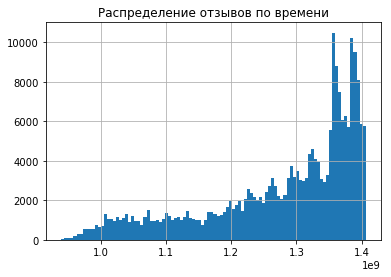

In [34]:
plt.title("Распределение отзывов по времени")
df.dt.hist(bins=100)

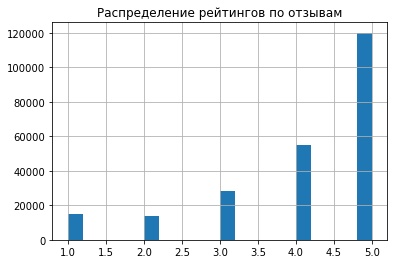

In [35]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist(bins=20)

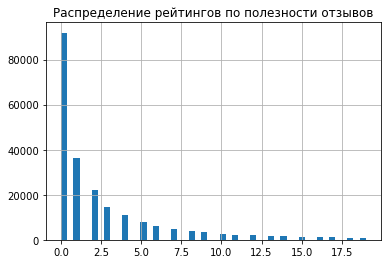

In [36]:
plt.title("Распределение рейтингов по полезности отзывов")
df.loc[df.helpful< 20].helpful.hist(bins=50)

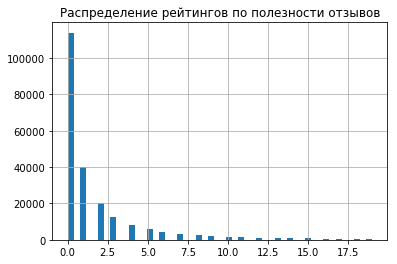

In [37]:
plt.title("Распределение рейтингов по полезности отзывов")
df.loc[df.unhelpful< 20].unhelpful.hist(bins=50)

In [38]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет

array([1])

In [39]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [40]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [41]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


In [42]:
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

In [43]:
#полготовим выборки для кросс-валидации - пока будем только на 1 фолд разбивать

In [44]:
#df__ = clean_df(df,5,10)

In [45]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


In [46]:
training_df, test_df = split_df_by_dt(df)
#del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 10) (46353, 10)
Размер после очистки: (185427, 10) (19174, 10)


In [47]:
training_df_, test_df_ = split_df_by_dt(training_df)

Min=939859200, border=1355097600.0, max=1377129600
Размер до очистки: (148429, 10) (36998, 10)
Размер после очистки: (148429, 10) (15356, 10)


 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [48]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [49]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict


In [50]:
test_dict = get_test_dict(test_df)

In [51]:
test_dict_ = get_test_dict(test_df_)

## Non-personalized RS

В первом подзадании студент должен построить неперсонализированную рекомендательную систему. Т.е. рекомендации для одного пользователя строятся на основе отзывов, оставленных всеми пользователями.

Ниже приведены базовые классы для рекомендателей, которые можно использовать при построении собственных моделей.

In [52]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid, top):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids, top):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid, top) for uid in uids}
    
class NonPersRecommender(BasicRecommender):
    def __init__(self, df):
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)
        
    def _prepare_recs(self, df):
        return pd.Series([])
    
    def get_recs(self, uid, top):
        
        return self.recs[:top].to_dict()
    
    def get_batch_recs(self, uids, top):
        #non_pers_recs = self.get_recs(None, top)
        return {uid: self.get_recs(self,uid,top) for uid in uids}

Пример неперсональной рекомендательной системы - система, рекомендующая наиболее популярный контент.

In [53]:
class MostReviewedRS(NonPersRecommender):
    def _prepare_recs(self, df):
        return df.iid.value_counts() 

#### Подберем параметры исходя из анализа данных - rating > (3;4)  dt >  (mean ;median) - helpful & unhelpful - пока не будем использовать
#### grid search писать свой лень - проверяем в лоб

In [54]:
mrds = MostReviewedRS

In [55]:
df__ = training_df_.loc[(training_df_.rating > 3 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03299675441759827

In [56]:
df__ = training_df_.loc[(training_df_.rating > 3 )
                        &(training_df_.dt > training_df_.dt.median())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.033357374684457264

In [57]:
df__ = training_df_.loc[(training_df_.rating > 4 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03858636855391273

In [58]:
df__ = training_df_.loc[(training_df_.rating > 4 )
                        &(training_df_.dt > training_df_.dt.median())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03804543815362423

In [59]:
## попробуем улучьшить с помощью дополнительной инофрмации helpful&unhelpful
## на 2-х лучших моделях

In [60]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.unhelpful < 10 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03858636855391273

In [61]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.unhelpful < 5 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03786512802019473

In [62]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.unhelpful < 1 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.04056978002163721

In [63]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.helpful < 10 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03786512802019473

In [64]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.helpful < 5 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03696357735304724

In [65]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.helpful < 1 )
                        &(training_df_.dt > training_df_.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.03407861521817526

In [66]:
df__ = training_df_.loc[(training_df_.rating > 4 )&(training_df_.unhelpful < 1)
                        &(training_df_.dt > training_df_.dt.median())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,df__.uid.values,10)
hit_ratio(rect,test_dict_)

0.04002884962134872

In [67]:
#проверим 2 лучших модели на тестовых данных

In [68]:
df__ = training_df.loc[(training_df.rating > 4 )&(training_df.unhelpful < 1 )
                        &(training_df.dt > training_df.dt.mean())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,training_df.uid.values,10)
hit_ratio(rect,test_dict)

0.07674247982391783

In [69]:
df__ = training_df.loc[(training_df.rating > 4 )&(training_df.unhelpful < 1 )
                        &(training_df.dt > training_df.dt.median())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,training_df.uid.values,10)
hit_ratio(rect,test_dict)

0.07762289068231841

In [70]:
## ответ удовлетворительный ) 
## если переобучиться на тестовой выборке - то:

In [71]:
df__ = training_df.loc[(training_df.rating > 4 )
                        &(training_df.dt > 1.064*training_df.dt.median())]
mrds.recs = mrds._prepare_recs(mrds, df__)
rect = mrds.get_batch_recs(mrds,training_df.uid.values,10)
hit_ratio(rect,test_dict)

0.10388848129126926

In [72]:
# но мы так не делаем )))

#### `HR@10` для non-personalized модели, созданной автором блокнота: 0.055

### Подсказки
Подумайте, какие игры обычно приобретают люди. 
* Какие свойства, помимо, популярности могут помочь покупателю выбрать игру, если у него нет явных предпочтений? 
* Можно ли как-нибудь использовать рейтинги или время публикации отзывов?

## Content-based RS

Простая content-based рекомендательная система описывает пользователей и объекты как вектора в некотором N-мерном пространстве фич. Вектор объекта показывает, насколько объект принадлежит к той или иной фиче. Вектор пользователя показывает, насколько пользователь предпочитает ту или иную фичу. Рекомендации строятся путем поиска объектов, чьи вектора похожи на вектор предпочтений пользователя. Предполагается, что чем более похожи вектора пользователя и объекта, тем интереснее этот объект пользователю.

#### `HR@10` для content-based, модели созданной автором блокнота: 0.065

## Создадим профиль объекта

In [73]:
from sklearn.metrics import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack, csr_matrix, hstack

In [74]:
from sklearn.preprocessing import normalize

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english' ) 

In [76]:
tfidf.fit(training_df.review )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [77]:
df_ = tfidf.transform(training_df.review)

In [78]:
# умножаем на rating  и на dt
df_ = df_.multiply(training_df.dt.values.reshape(-1, 1)).tocsr()
df_ = df_.multiply(training_df.rating.values.reshape(-1, 1)).tocsr()

In [79]:
df_.shape

(185427, 197239)

In [80]:
#Профиль обьекта
def get_item_profile(iid):
    r = np.where(training_df.iid == iid)[0]
    return csr_matrix(df_[r].sum(axis=0))

In [81]:
%%time
get_item_profile(10376)

CPU times: user 5.43 ms, sys: 10.9 ms, total: 16.4 ms
Wall time: 15.5 ms


<1x197239 sparse matrix of type '<class 'numpy.float64'>'
	with 116 stored elements in Compressed Sparse Row format>

In [82]:
%%time
#Профили обьектов
item_profiles = []
items_iid = {}
for i in training_df.iid.unique():
    items_iid[i] = len(item_profiles)
    item_profiles.append(get_item_profile(i))

item_profiles = normalize(vstack(item_profiles, format='csr'))

CPU times: user 33.1 s, sys: 320 ms, total: 33.4 s
Wall time: 33.4 s


In [83]:
item_profiles.shape

(10098, 197239)

## Создадим профиль пользователя

In [84]:
# пользовательский профиль
def get_user_profile(uid):
    uid_df = training_df.loc[training_df.uid == uid]  
    X = []
    y = uid_df.rating*uid_df.dt

    items = []
    for t in uid_df.itertuples():
        items.append(items_iid[t.iid])
    y = np.array(y)
    X = item_profiles[items]
    
    X = X.multiply(y.reshape(-1, 1)).tocsr()
    a = 0
    b = 1
    c = 1
    r = np.where(y > uid_df.rating.mean())[0]
    nr = np.where(y <= uid_df.rating.mean())[0]
    low = 0
    high = 0
    if  nr.size !=0: 
        low = - c * X[nr].sum(axis=0)/nr.size
    if r.size !=0: 
        high = b*X[r].sum(axis=0)/r.size 
    user_profile =  high - low
    return  csr_matrix(user_profile)
    #return  csr_matrix(X.sum(axis=0))

In [85]:
%%time
get_user_profile(6)

CPU times: user 18.9 ms, sys: 1.64 ms, total: 20.5 ms
Wall time: 9.87 ms


<1x197239 sparse matrix of type '<class 'numpy.float64'>'
	with 1199 stored elements in Compressed Sparse Row format>

In [86]:
%%time
#матрица пользовательских профилей

user_profiles = []
users_uid = {}
for i in training_df.uid.unique():
    users_uid[i] = len(user_profiles)
    user_profiles.append(get_user_profile(i))

user_profiles = normalize(vstack(user_profiles, format='csr'))

CPU times: user 13min 7s, sys: 16.9 s, total: 13min 24s
Wall time: 3min 28s


In [87]:
ftr_iid_m = item_profiles.T.tocsr()
row_to_iid = {row_id: iid for iid, row_id in items_iid.items()}

In [88]:
def get_recs(uid):
    recs = {}
    if uid in users_uid:
        u_row_id = users_uid[uid]
        u_row = user_profiles[u_row_id]

        # самописный cosine similarity
        u_recs = u_row.dot(ftr_iid_m)
        users_items = training_df.loc[training_df.uid == uid].iid.values
        
        i = 0
        for arg_id in np.argsort(np.abs(u_recs.data))[::-1]:
            row_id = u_recs.indices[arg_id]
#             убираем элементы которые уже имеют рекомендации пользователя
            
            if (row_to_iid[row_id] not in users_items) :
                row_id = u_recs.indices[arg_id]
                score = u_recs.data[arg_id]
                recs[row_to_iid[row_id]] = score
                i = i + 1
            if i == 10 : break
                
    return recs

In [89]:
def get_rects(df_):
    rect = {}
    for t in df_.uid.unique():
        itm = get_recs(t)
        rect[t] = itm
    return rect

In [90]:
%%time
re = get_rects(training_df)

CPU times: user 5min 3s, sys: 1.59 s, total: 5min 4s
Wall time: 5min 7s


In [91]:
hit_ratio(re, test_dict)

0.07732942039618489

## hit_ratio -- 0.07732942039618489

## Item-based collaborative filtering RS

Item-based CF основан на идее, что пользователь предпочтет объекты, похожие на те, что он приобретал ранее. Данные в CF модели представлены матрицей `user x item`, где ячейка матрицы соответствует рейтингу, который пользователь поставил объекту. Вместо рейтингов в матрице могут быть вероятности (т.е. вероятность, что пользователь воспользуется объектом). Для работы модели необходимо построить матрицу `item x item` схожести объектов. Обычно для построения матрицы схожести используется исходная матрица `user x item`. Чтобы уменьшить шумы в матрице схожести, для каждого объекта хранят только $K$ наиболее похожих объектов.

В простейшем случае рекомендации строятся путем нахождения объектов с наибольшим значением предсказанного рейтинга:
$$\hat{r}_{ui} = \frac{\sum_{j \in I_u} r_{uj} * sim(j, i)}{\sum_{j \in I_u} r_{uj}}$$

* $I_u$ - множество объектов, оцененных пользователем
* $sim(j, i)$ - схожесть между объектами $j$ и $i$

Часто из финальных рекомендаций для пользователя $u$ исключаются объекты $I_u$.

In [92]:
# вспомогательные функции, которые могут пригодиться при построении Item-based CF
def nullify_main_diagonal(m):
    positions = range(m.shape[0])
    eye = csr_matrix((np.ones(len(positions)), (positions, positions)), m.shape)
    return m - m.multiply(eye)


def get_topk(matrix, top, axis=1):
    """Converts source matrix to Top-K matrix
    where each row or column contains only top K values

    :param matrix: source matrix
    :param top: number of top items to be stored
    :param axis: 0 - top by column, 1 - top by row
    :return:
    """
    rows = []
    cols = []
    data = []

    if axis == 0:
        matrix = matrix.T.tocsr()

    for row_id, row in enumerate(matrix):
        if top is not None and row.nnz > top:
            top_args = np.argsort(row.data)[-top:]

            rows += [row_id] * top
            cols += row.indices[top_args].tolist()
            data += row.data[top_args].tolist()
        elif row.nnz > 0:
            rows += [row_id] * row.nnz
            cols += row.indices.tolist()
            data += row.data.tolist()

    topk_m = csr_matrix((data, (rows, cols)), (matrix.shape[0], matrix.shape[1]))

    if axis == 0:
        topk_m = topk_m.T.tocsr()

    return topk_m

In [93]:
from sklearn.preprocessing import binarize

In [94]:
def load_data(df):
    rows = []
    cols = []
    data = []
    
    uid_to_row = {}
    iid_to_col = {}
    
    for t in df.itertuples():
        row_id = uid_to_row.setdefault(t.uid, len(uid_to_row))
        col_id = iid_to_col.setdefault(t.iid, len(iid_to_col))
        rating = t.rating*t.dt
        
        rows.append(row_id)
        cols.append(col_id)
        data.append(rating)
        
    ui_m = csr_matrix((data, (rows, cols)))
    return ui_m, uid_to_row, iid_to_col

In [95]:
ui_m, uid_to_row, iid_to_col = load_data(training_df)

In [96]:
ui_m.shape

(22215, 10098)

In [97]:
print("Density", ui_m.nnz / (ui_m.shape[0] * ui_m.shape[1]))
print("Max sim", ui_m.data.max())
print("Min sim", ui_m.data.min())
print("Shape", ui_m.shape)

Density 0.0008265921718676217
Max sim 6885648000.0
Min sim 943574400.0
Shape (22215, 10098)


In [98]:
n_ui_m = normalize(ui_m)

In [99]:
print("Density", n_ui_m.nnz / (n_ui_m.shape[0] * n_ui_m.shape[1]))
print("Max sim", n_ui_m.data.max())
print("Min sim", n_ui_m.data.min())
print("Shape", n_ui_m.shape)

Density 0.0008265921718676217
Max sim 1.0
Min sim 0.00736786528079
Shape (22215, 10098)


In [100]:
from sklearn.metrics.pairwise import cosine_similarity


In [101]:
ii_sim_m = cosine_similarity(ui_m.T, dense_output=False).tocsr()

In [102]:
ii_sim_m.shape

(10098, 10098)

In [103]:
print("Density", ii_sim_m.nnz / (ii_sim_m.shape[0] * ii_sim_m.shape[1]))
print("Max sim", ii_sim_m.data.max())
print("Min sim", ii_sim_m.data.min())
print("Shape", ii_sim_m.shape)

Density 0.038468718580097656
Max sim 1.0
Min sim 0.000164135673565
Shape (10098, 10098)


In [104]:
ii_sim_m = nullify_main_diagonal(ii_sim_m)

In [105]:
ii_sim_m = get_topk(ii_sim_m, top=20)

In [106]:
print("Density", ii_sim_m.nnz / (ii_sim_m.shape[0] * ii_sim_m.shape[1]))
print("Max sim", ii_sim_m.data.max())
print("Min sim", ii_sim_m.data.min())
print("Shape", ii_sim_m.shape)

Density 0.0019621435423050186
Max sim 1.0
Min sim 0.00233160200692
Shape (10098, 10098)


In [107]:
ii_sim_m = normalize(ii_sim_m)

In [108]:
print("Density", ii_sim_m.nnz / (ii_sim_m.shape[0] * ii_sim_m.shape[1]))
print("Max sim", ii_sim_m.data.max())
print("Min sim", ii_sim_m.data.min())
print("Shape", ii_sim_m.shape)

Density 0.0019621435423050186
Max sim 1.0
Min sim 0.00311523564856
Shape (10098, 10098)


In [109]:
col_to_iid = {col_id: iid for iid, col_id in iid_to_col.items()}

In [110]:
def get_recs(uid):
    r = {}
    recs_ = n_ui_m[uid_to_row[uid]].dot(ii_sim_m.T)
    users_items = training_df.loc[training_df.uid == uid].iid.values
    i = 0
    for arg_id in np.argsort(np.abs(recs_.data))[::-1]:
        if (col_to_iid[recs_.indices[arg_id]] not in users_items) :
            iid = col_to_iid[recs_.indices[arg_id]]
            score = recs_.data[arg_id]
            r[iid] = score
            i = i + 1
        if i == 10 : break
    return r

In [111]:
def get_recs_(df_):
    rect = {}
    for t in df_.uid.unique():
        itm = get_recs(t)
        rect[t] = itm
    return rect

In [112]:
get_recs(148)

{1920: 0.10340284799668181,
 6793: 0.1552677309841024,
 6803: 0.10444197891191809,
 7562: 0.10578073407643011,
 7591: 0.13342840659943753,
 8716: 0.11453069906669908,
 8718: 0.23704206795992144,
 8719: 0.20245434582808,
 9110: 0.18617589230237275,
 9578: 0.20454077884220512}

In [113]:
%%time
re = get_recs_(training_df)

CPU times: user 1min 29s, sys: 332 ms, total: 1min 29s
Wall time: 1min 29s


In [114]:
hit_ratio(re, test_dict)

0.08613352898019075

### hit_ratio -- 0.08613352898019075

#### `HR@10` для item-based CF модели, созданной автором блокнота: 0.085

### Подcказки
* Определитесь с тем, что вы пытаетесь предсказать (рейтинги, вероятности, ...)
* Оптимальный способ вычисления матрицы схожести выглядит так:
 * Привести строки в матрице `user x item` к единичной длине (выделяет основные предпочтения пользователя)
 * Построить матрицу схожести `item x item`
 * Для каждого объекта оставить только $K$ наиболее похожих объектов
 * Для каждого объекта привести к единичной длине вектор схожести этого объекта (выделяет наиболее схожие объекты)
* Удалили ли вы из рекомендаций объекты, которые пользователь уже оценивал?
* Статья "Item-Based Top-N Recommendation Algorithms", Mukund Deshpande и George Karypis

## Hybrid RS

Гибридная рекомендательная система - это объединение нескольких рекомендательных систем (мы не будем перечислять тут возможные способы гибридизации). Цель гибридизации - воспользоваться сильными сторонами нескольких моделей, чтобы улучшить качество рекомендаций.

В данном задании студент должен создать гибридную систему, состояющую **как минимум** из двух подсистем.

#### `HR@10` для гибридной модели, созданной автором блокнота: 0.096

### Подcказки
* Определите сильные и слабые стороны различных моделей
* Какие из них коррелируют? А какие могут дополнять друг друга?
* Только конечный результат работы системы должен содержать $N$ рекомендаций (промежуточные могут содержать больше)

In [115]:
def get_rec(uid, top=10):
    r = {}
    recs_ = n_ui_m[uid_to_row[uid]].dot(ii_sim_m.T)
    
    u_row_id = users_uid[uid]
    u_row = user_profiles[u_row_id]
    u_recs = u_row.dot(ftr_iid_m)
    #Суммируем результаты CBRS и Item-based collaborative filtering RS
    recs_ =  recs_ + u_recs
    
    users_items = training_df.loc[training_df.uid == uid].iid.values
    i = 0
    for arg_id in np.argsort(np.abs(recs_.data))[::-1]:
        if (col_to_iid[recs_.indices[arg_id]] not in users_items) :
            iid = col_to_iid[recs_.indices[arg_id]]
            score = recs_.data[arg_id]
            r[iid] = score
            i = i + 1
        if i == 10 : break
    return r


In [116]:
def get_recs___(df_):
    rect = {}
    for t in df_.uid.unique():
        itm = get_rec(t,10)
        rect[t] = itm
    return rect

In [117]:
%%time
re = get_recs___(training_df)

CPU times: user 6min 12s, sys: 756 ms, total: 6min 13s
Wall time: 6min 14s


In [118]:
hit_ratio(re, test_dict)

0.10212765957446808

Сравним с не кипеченной вещью - те с неперсонализированной рекомендацией

In [119]:
get_rec(148)

{6793: 0.69206454384208194,
 6798: 0.64181422344285433,
 6803: 0.6792805921316496,
 6879: 0.62406296913800119,
 6936: 0.65241808940880908,
 7591: 0.69827821726315364,
 8554: 0.65299547254434043,
 8718: 0.77265024574625329,
 8719: 0.70163595688434499,
 9578: 0.71843363641405145}

In [120]:
rect[148]

{3536: 77,
 5390: 41,
 7163: 43,
 7599: 32,
 8159: 59,
 8160: 36,
 8401: 45,
 8659: 37,
 8717: 64,
 9267: 227}